<a href="https://colab.research.google.com/github/bbhargava/Natural-Language-Processing-ML-model-deployment-at-AWS/blob/main/Disaster_Tweet_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

import re
import os
import string

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam


In [3]:
tweet = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/twitter-disaster-prediction-dataset/refs/heads/master/train.csv")

In [4]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
tweet.shape

(7613, 5)

In [6]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# Data Analysis

## Target Class Distribution

In [7]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 80


Text(0.5, 1.0, 'Real or not real disaster tweets')

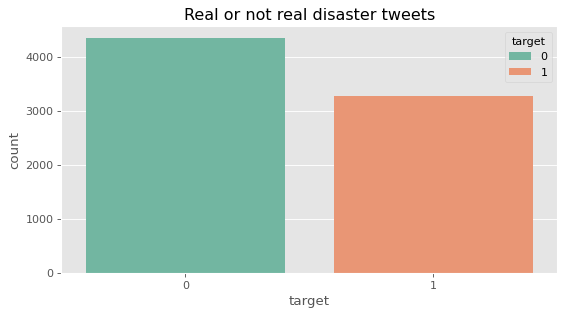

In [8]:
sns.countplot(tweet, x="target", hue="target", palette = "Set2")
plt.title('Real or not real disaster tweets')

In [9]:
tweet['target'].value_counts()

,count
target,
0,4342
1,3271


<Axes: ylabel='count'>

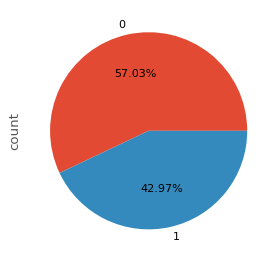

In [10]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

# Number of Characters in tweet distribution

In [12]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie_old.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie_old.git to /tmp/pip-req-build-7liaaobk
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie_old.git /tmp/pip-req-build-7liaaobk
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie_old.git to commit e5b1f0710cb1ea5ebbc73d30abe8d45a07cbb399
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess_kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7617 sha256=0c86cead83a3749dbc762dd9743d289d9bc6395ccdff29883c5134d162ee0b0a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ty3j1pr7/wheels/c0/00/89/c571736e96e582dfd8410b0177274991bd821016a96af3f958
Successfully built preprocess_kgptalkie


In [13]:
import preprocess_kgptalkie as kgp

In [14]:
kgp.get_basic_features(tweet)

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,73,11,6.636364,2,0,0,2,0
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,106,20,5.300000,9,0,2,2,0
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,58,8,7.250000,1,0,0,7,2
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,119,19,6.263158,6,0,0,2,0


<ipython-input-15-72f162dc66a6>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tweet['char_counts'])


<Axes: xlabel='char_counts', ylabel='Density'>

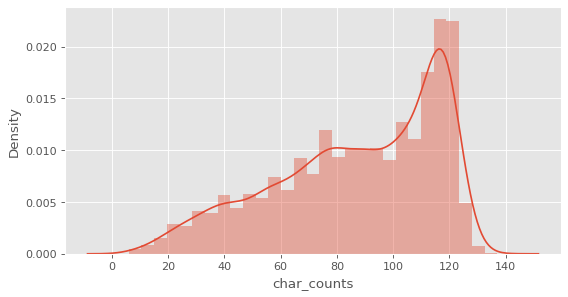

In [15]:
sns.distplot(tweet['char_counts'])

<Axes: xlabel='char_counts', ylabel='Density'>

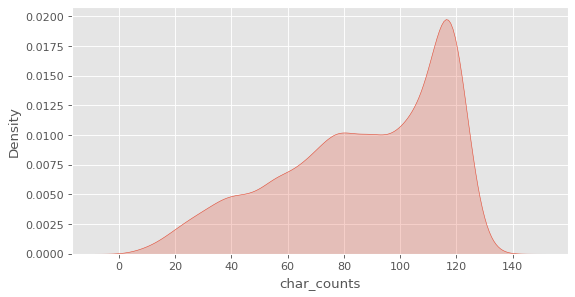

In [20]:
sns.kdeplot(tweet['char_counts'], fill=True)

<Axes: xlabel='char_counts', ylabel='Density'>

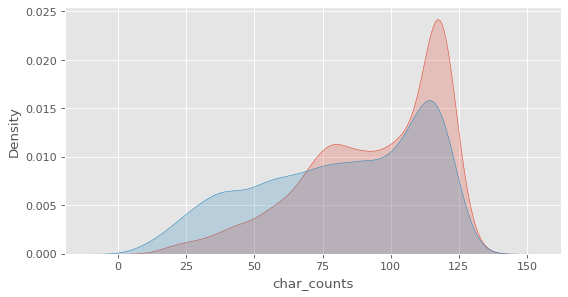

In [25]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'], fill=True)
sns.kdeplot(tweet[tweet['target']==0]['char_counts'], fill=True)

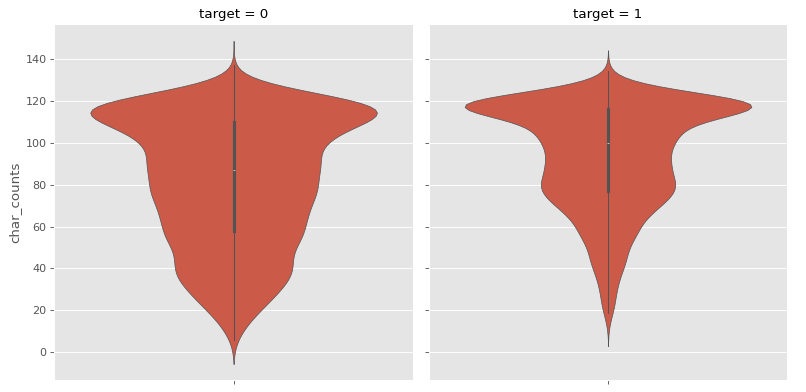

In [27]:
sns.catplot(y='char_counts',data=tweet, kind='violin', col='target')